# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [8]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [9]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

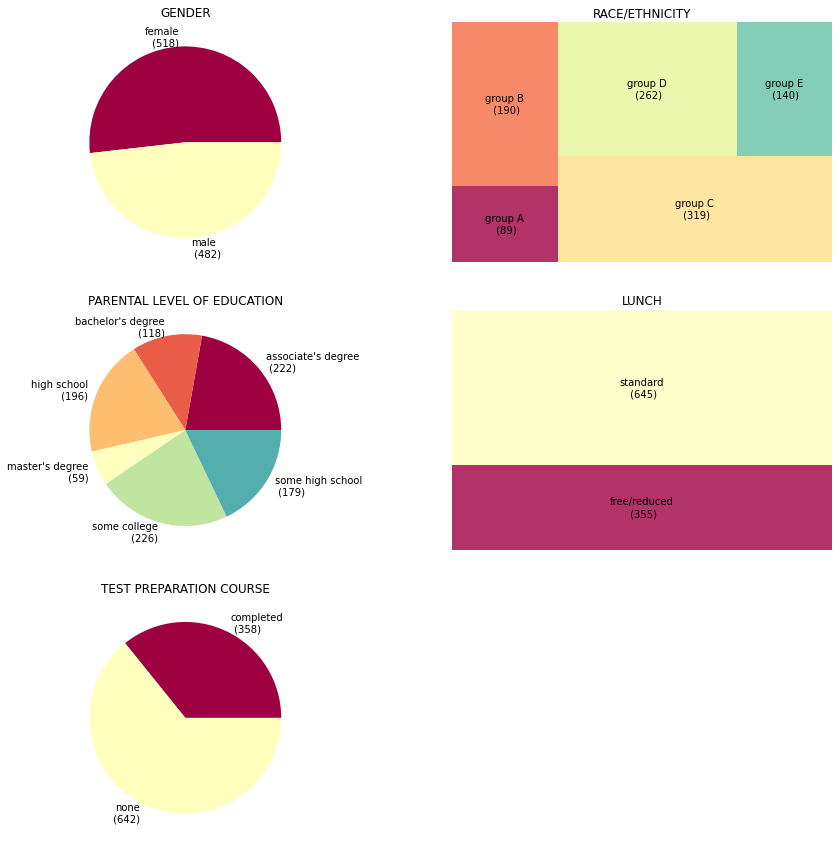

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Numeričke značajke 

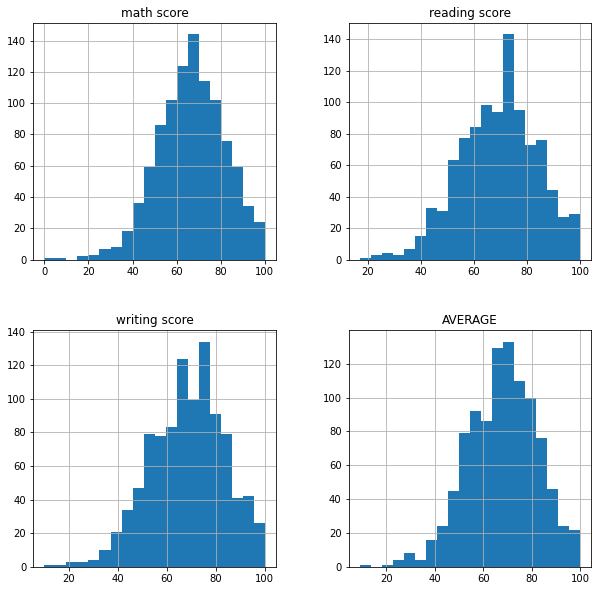

In [6]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

## Usporedba spola

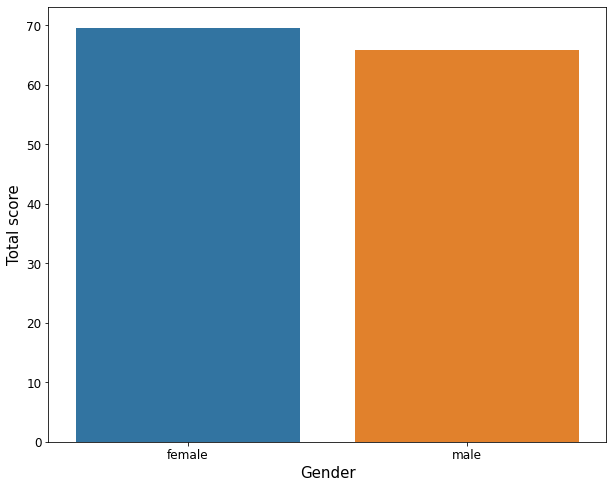

In [7]:
df['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
plt.figure(figsize = (10,8))
sns.barplot(data = df, x = 'gender', y = 'Total score', ci = False)
plt.xticks(fontsize = 12)
plt.xlabel('Gender', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Total score', fontsize = 15)
plt.show()

 
    

## Utjecaj priprema za ispit na rezultate 

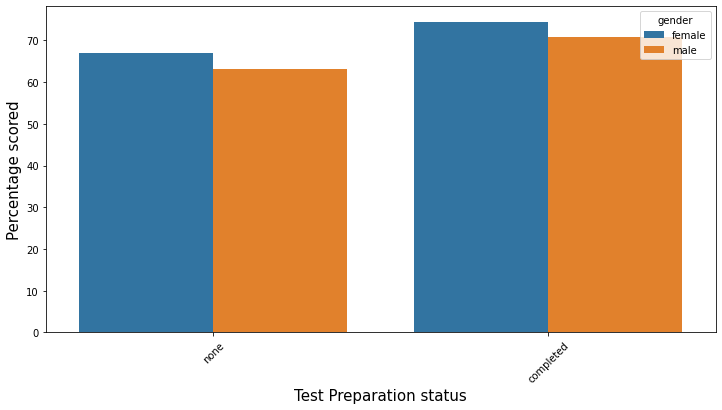

In [8]:
plt.figure(figsize = (12,6))
sns.barplot(data = df, x = 'test preparation course', y = 'Total score', hue = 'gender', ci = False)
plt.xlabel('Test Preparation status', fontsize = 15)
plt.xticks(rotation = 45)
plt.ylabel('Percentage scored', fontsize = 15)
plt.show()

df = df.drop(["Total score"],axis = 'columns')

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [9]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [10]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(data, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })




def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    #target= table["AVERAGE"]
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [11]:
def odaberi(algorithm,k,train_X, train_y,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(train_X, train_y)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(train_X.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, train_X.shape[1]])
    plt.xticks(range(train_X.shape[1]), train_X.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : ONE HOT ENCODING

In [12]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [13]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')


### Rezultat s metodom: f_regression

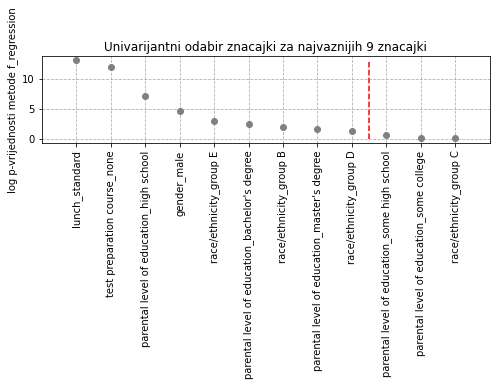

In [14]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

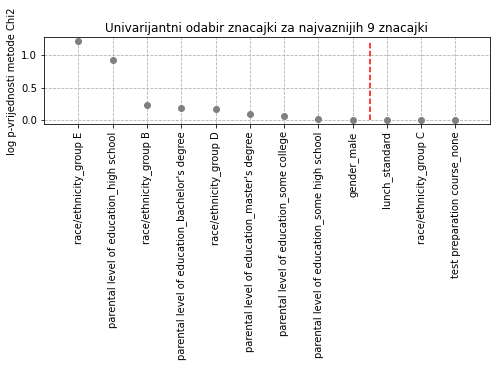

In [15]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

### 2.Odabir encodinga za feature selection : LABEL


In [16]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [17]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')

### Rezultat s metodom: f_regression

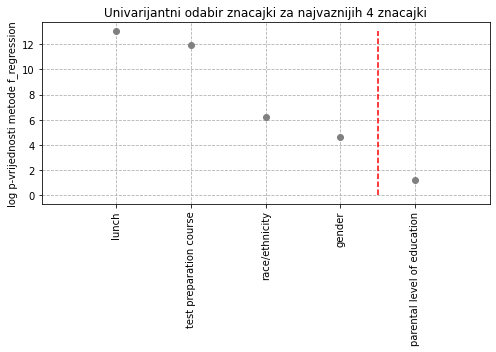

In [18]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

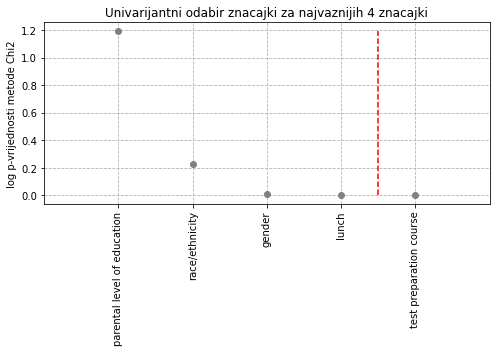

In [19]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [198]:
def residual(true,pred):
    resid = true - pred
    print( np.sqrt(np.mean(resid*resid)) )
def evaluateRegressor(true,predicted,message = "Test set evaluation:"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")
    return [MSE,MAE,RMSE,R_squared]

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

In [12]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

Y_class= pd.cut(Y,
       5, labels=[1,2,3,4,5])

train_X, valid_X, train_y, valid_y = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

#train_y_N=train_y_N.astype('int')

In [13]:
df_temp = df.copy()
df_temp['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
df_temp=df_temp.drop(["AVERAGE"],axis = 'columns')

In [14]:
df2 = one_hot_encoding(df_temp)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

### Evaluacije spremamo u tablicu

In [274]:
data=[]
data=pd.DataFrame(data, columns=["MSE", "MAE","RMSE", "R^2"])
data.index.astype(str, copy = False)

data

,MSE,MAE,RMSE,R^2


## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [275]:
model = Pipeline([ ('linear', LinearRegression()) ])
model = model.fit(features, targets)

regr_pred = model.predict(test.loc[:, 'gender' : 'test preparation course'])
#print(regr_pred)

correct_scores = test.loc[:, 'math score' : 'Total score']
explained_variance = explained_variance_score(correct_scores, regr_pred)
R2 = r2_score(correct_scores, regr_pred)
MSE = mean_squared_error(correct_scores, regr_pred)

print('Objasnjena varijanca = '+'{0:.2f}'.format(explained_variance)+'\nR2 = '+'{0:.2f}'.format(R2)+'\nMSE = '+'{0:.2f}'.format(MSE))

Objasnjena varijanca = 0.28
R2 = 0.27
MSE = 168.72


In [276]:
def lin_reg(X,y):
    LinearReg = LinearRegression(normalize = True)
    LinearReg = LinearReg.fit(X,y)

    return LinearReg


In [277]:
model_LINEAR = lin_reg(train_X,train_y)

predicted_valid_y = model_LINEAR.predict(valid_X)

In [278]:
residual(valid_y, predicted_valid_y)

data.loc['linearna'] = evaluateRegressor(valid_y, predicted_valid_y)


12.676343813132048
Test set evaluation:
MSE: 160.68969246873115
MAE: 10.154567169775646
RMSE: 12.676343813132048
R-squared: 0.15637127054953737 , from <0,1> 


### MultitaskLasso Regresija (3 izlaza)

In [279]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [280]:
train_X_lasso, valid_X_lasso, train_y_lasso, valid_y_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [281]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(train_X_lasso,train_y_lasso)

pred=MTL.predict(valid_X_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(valid_X_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [282]:
residual(valid_y_lasso, pred)

print("\nScores:")

data.loc['Multi-Lasso'] = evaluateRegressor(valid_y_lasso, pred)

math score       13.417021
reading score    13.527676
writing score    13.176069
dtype: float64

Scores:
Test set evaluation:
MSE: 178.87442198968702
MAE: 10.99907421373472
RMSE: 13.373588683723844
R-squared: 0.2301108220132274 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.27
R2 = 0.27
MSE = 170.19


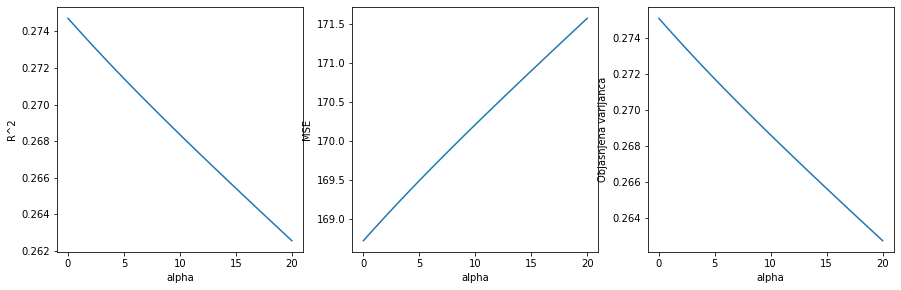

In [283]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    
    
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))


ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## LightGBM

In [284]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(train_X,train_y)

predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)


data.loc['LightGBM'] = evaluateRegressor(valid_y,predicted_valid_y)


    Training Set
MSE: 136.47240084210512
MAE: 9.356612289990458
RMSE: 11.682140250917428
R-squared: 0.33818522970221265 , from <0,1> 
Test set evaluation:
MSE: 170.1180404746157
MAE: 10.250945638352162
RMSE: 13.042930670467266
R-squared: 0.10687198327839531 , from <0,1> 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

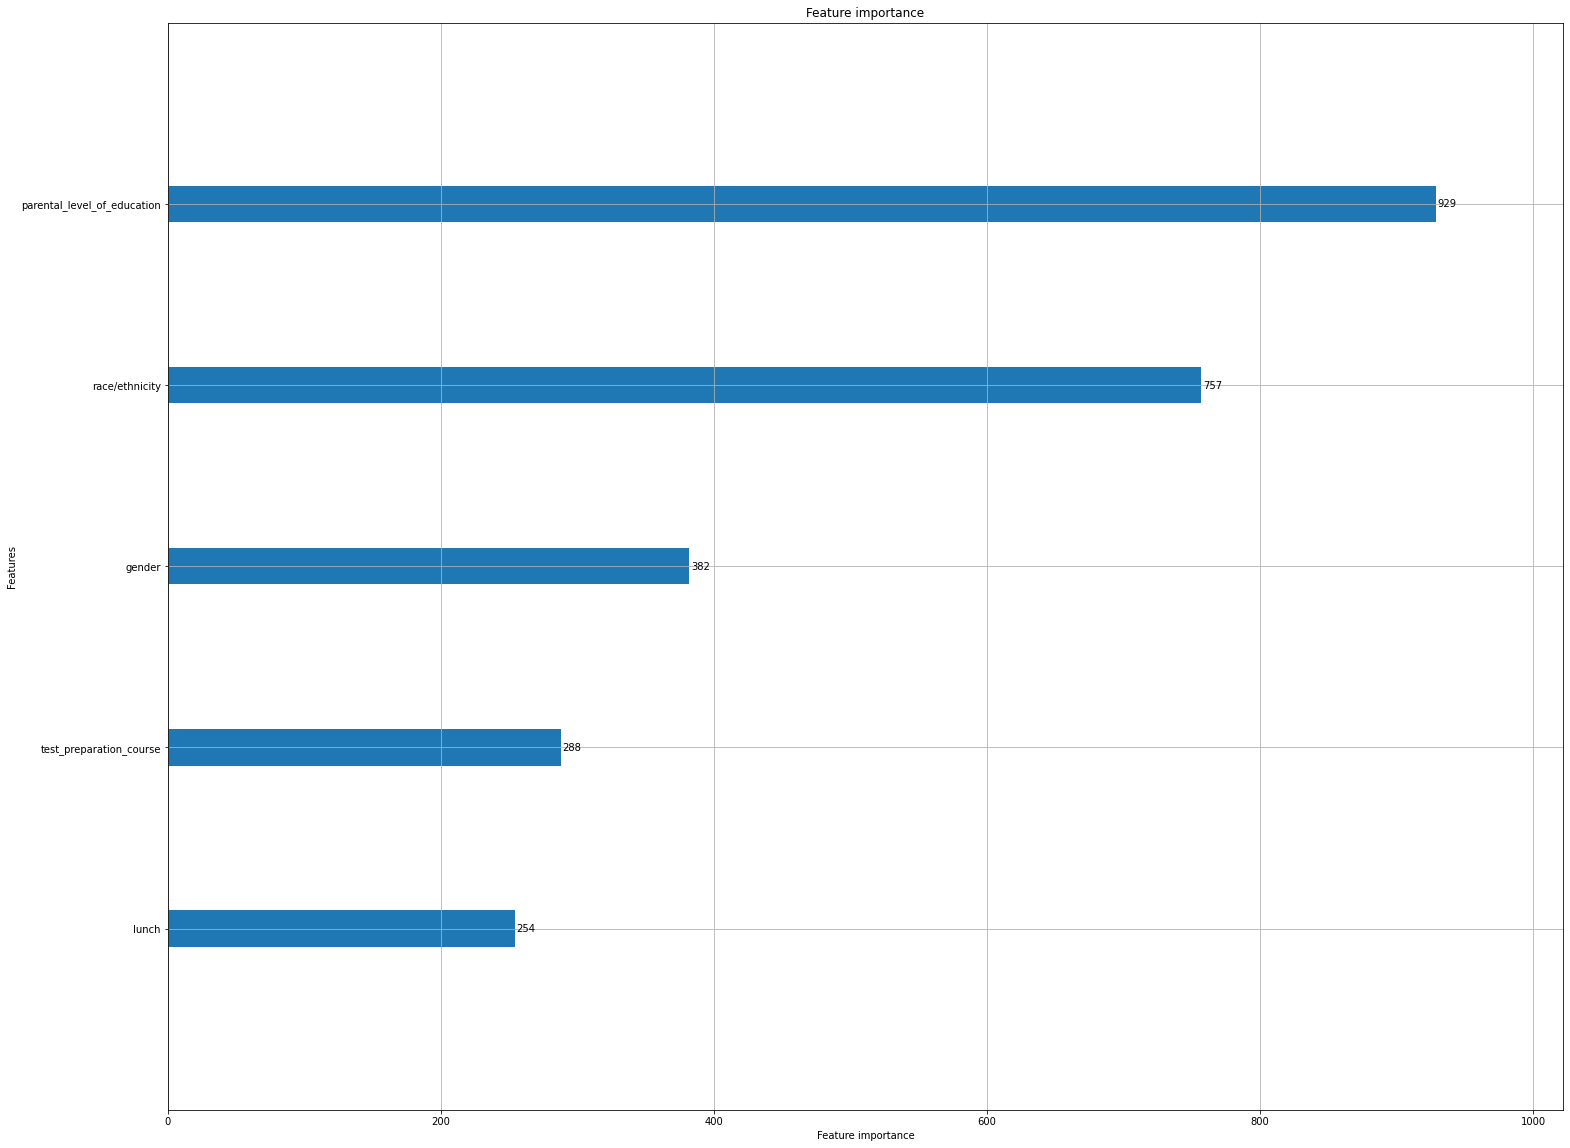

In [285]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

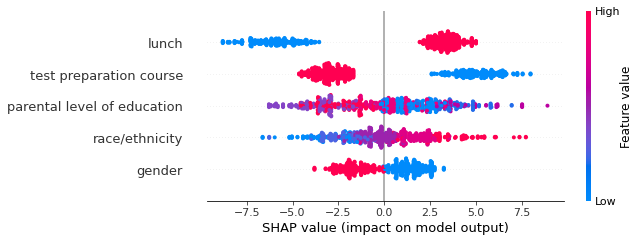

In [286]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

## CATBoost

### Pretraživanje hiperparametra: $iterations$

In [287]:
from catboost import CatBoostRegressor

train_data = train_X
eval_data = valid_X
train_labels = train_y


k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)


for i in np.arange(1,k+1):
        # Initialize CatBoostRegressor
    model = CatBoostRegressor(iterations=i,
                              learning_rate=1,
                              depth=2)
    # Fit model
    model.fit(train_data, train_labels)
    
    
    treeScoresTrain1[i-1]=r2_score(train_y, model.predict(train_X))
    treeScoresTest1[i-1] =r2_score(valid_y, model.predict(valid_X))
    treeScoresTrain2[i-1]= max_error(train_y, model.predict(train_X))
    treeScoresTest2[i-1] = max_error(valid_y, model.predict(valid_X))
    treeScoresTrain3[i-1]= mean_squared_error (train_y, model.predict(train_X))
    treeScoresTest3[i-1] = mean_squared_error (valid_y, model.predict(valid_X))


0:	learn: 13.0578783	total: 601us	remaining: 0us
0:	learn: 13.0578783	total: 1.06ms	remaining: 1.06ms
1:	learn: 12.9584530	total: 2.18ms	remaining: 0us
0:	learn: 13.0578783	total: 622us	remaining: 1.24ms
1:	learn: 12.9584530	total: 1.2ms	remaining: 601us
2:	learn: 12.6504686	total: 1.88ms	remaining: 0us
0:	learn: 13.0578783	total: 621us	remaining: 1.86ms
1:	learn: 12.9584530	total: 1.44ms	remaining: 1.44ms
2:	learn: 12.6504686	total: 1.98ms	remaining: 659us
3:	learn: 12.6153855	total: 2.69ms	remaining: 0us
0:	learn: 13.0578783	total: 633us	remaining: 2.53ms
1:	learn: 12.9584530	total: 1.19ms	remaining: 1.78ms
2:	learn: 12.6504686	total: 1.84ms	remaining: 1.23ms
3:	learn: 12.6153855	total: 2.31ms	remaining: 577us
4:	learn: 12.5517572	total: 2.81ms	remaining: 0us
0:	learn: 13.0578783	total: 587us	remaining: 2.94ms
1:	learn: 12.9584530	total: 1.23ms	remaining: 2.46ms
2:	learn: 12.6504686	total: 1.97ms	remaining: 1.97ms
3:	learn: 12.6153855	total: 2.52ms	remaining: 1.26ms
4:	learn: 12.5517

0:	learn: 13.0578783	total: 595us	remaining: 10.7ms
1:	learn: 12.9584530	total: 1.14ms	remaining: 9.67ms
2:	learn: 12.6504686	total: 1.67ms	remaining: 8.92ms
3:	learn: 12.6153855	total: 2.2ms	remaining: 8.27ms
4:	learn: 12.5517572	total: 2.91ms	remaining: 8.15ms
5:	learn: 12.5087184	total: 3.61ms	remaining: 7.82ms
6:	learn: 12.4783454	total: 4.14ms	remaining: 7.1ms
7:	learn: 12.4666198	total: 4.67ms	remaining: 6.41ms
8:	learn: 12.4522725	total: 5.18ms	remaining: 5.76ms
9:	learn: 12.4282418	total: 5.69ms	remaining: 5.12ms
10:	learn: 12.4087901	total: 6.21ms	remaining: 4.52ms
11:	learn: 12.3938148	total: 6.7ms	remaining: 3.91ms
12:	learn: 12.3858347	total: 7.35ms	remaining: 3.39ms
13:	learn: 12.3769657	total: 8.8ms	remaining: 3.14ms
14:	learn: 12.3615643	total: 9.68ms	remaining: 2.58ms
15:	learn: 12.3546051	total: 10.3ms	remaining: 1.93ms
16:	learn: 12.3510371	total: 11.9ms	remaining: 1.4ms
17:	learn: 12.3437469	total: 12.5ms	remaining: 694us
18:	learn: 12.3352356	total: 13.2ms	remaining

7:	learn: 12.4666198	total: 4.62ms	remaining: 10.4ms
8:	learn: 12.4522725	total: 5.22ms	remaining: 9.86ms
9:	learn: 12.4282418	total: 6ms	remaining: 9.59ms
10:	learn: 12.4087901	total: 6.73ms	remaining: 9.18ms
11:	learn: 12.3938148	total: 7.29ms	remaining: 8.5ms
12:	learn: 12.3858347	total: 8.3ms	remaining: 8.3ms
13:	learn: 12.3769657	total: 8.78ms	remaining: 7.52ms
14:	learn: 12.3615643	total: 9.26ms	remaining: 6.79ms
15:	learn: 12.3546051	total: 9.76ms	remaining: 6.1ms
16:	learn: 12.3510371	total: 10.3ms	remaining: 5.43ms
17:	learn: 12.3437469	total: 10.7ms	remaining: 4.76ms
18:	learn: 12.3352356	total: 11.2ms	remaining: 4.11ms
19:	learn: 12.3299746	total: 11.6ms	remaining: 3.49ms
20:	learn: 12.3257477	total: 12.1ms	remaining: 2.89ms
21:	learn: 12.3213673	total: 12.6ms	remaining: 2.3ms
22:	learn: 12.3178344	total: 13.2ms	remaining: 1.72ms
23:	learn: 12.3116198	total: 14ms	remaining: 1.17ms
24:	learn: 12.3110103	total: 14.5ms	remaining: 580us
25:	learn: 12.3021519	total: 15.2ms	remain

28:	learn: 12.2937687	total: 19.5ms	remaining: 2.02ms
29:	learn: 12.2928413	total: 20ms	remaining: 1.33ms
30:	learn: 12.2925955	total: 20.5ms	remaining: 660us
31:	learn: 12.2913228	total: 21.2ms	remaining: 0us
0:	learn: 13.0578783	total: 620us	remaining: 19.9ms
1:	learn: 12.9584530	total: 1.18ms	remaining: 18.2ms
2:	learn: 12.6504686	total: 1.65ms	remaining: 16.5ms
3:	learn: 12.6153855	total: 2.09ms	remaining: 15.2ms
4:	learn: 12.5517572	total: 2.54ms	remaining: 14.2ms
5:	learn: 12.5087184	total: 3ms	remaining: 13.5ms
6:	learn: 12.4783454	total: 3.45ms	remaining: 12.8ms
7:	learn: 12.4666198	total: 3.92ms	remaining: 12.3ms
8:	learn: 12.4522725	total: 5.4ms	remaining: 14.4ms
9:	learn: 12.4282418	total: 5.96ms	remaining: 13.7ms
10:	learn: 12.4087901	total: 6.51ms	remaining: 13ms
11:	learn: 12.3938148	total: 7.03ms	remaining: 12.3ms
12:	learn: 12.3858347	total: 7.66ms	remaining: 11.8ms
13:	learn: 12.3769657	total: 8.27ms	remaining: 11.2ms
14:	learn: 12.3615643	total: 9.07ms	remaining: 10.9

33:	learn: 12.2842046	total: 18.3ms	remaining: 2.68ms
34:	learn: 12.2822384	total: 18.8ms	remaining: 2.14ms
35:	learn: 12.2813986	total: 19.3ms	remaining: 1.61ms
36:	learn: 12.2773761	total: 19.9ms	remaining: 1.07ms
37:	learn: 12.2740745	total: 20.4ms	remaining: 535us
38:	learn: 12.2722739	total: 20.8ms	remaining: 0us
0:	learn: 13.0578783	total: 614us	remaining: 24ms
1:	learn: 12.9584530	total: 1.46ms	remaining: 27.7ms
2:	learn: 12.6504686	total: 2ms	remaining: 24.7ms
3:	learn: 12.6153855	total: 2.54ms	remaining: 22.8ms
4:	learn: 12.5517572	total: 3.07ms	remaining: 21.5ms
5:	learn: 12.5087184	total: 3.8ms	remaining: 21.6ms
6:	learn: 12.4783454	total: 4.65ms	remaining: 21.9ms
7:	learn: 12.4666198	total: 5.29ms	remaining: 21.2ms
8:	learn: 12.4522725	total: 5.85ms	remaining: 20.1ms
9:	learn: 12.4282418	total: 6.35ms	remaining: 19ms
10:	learn: 12.4087901	total: 6.82ms	remaining: 18ms
11:	learn: 12.3938148	total: 7.36ms	remaining: 17.2ms
12:	learn: 12.3858347	total: 7.96ms	remaining: 16.5ms

1:	learn: 12.9584530	total: 1.46ms	remaining: 30.7ms
2:	learn: 12.6504686	total: 2.04ms	remaining: 27.8ms
3:	learn: 12.6153855	total: 2.58ms	remaining: 25.8ms
4:	learn: 12.5517572	total: 3.14ms	remaining: 24.5ms
5:	learn: 12.5087184	total: 3.72ms	remaining: 23.6ms
6:	learn: 12.4783454	total: 4.55ms	remaining: 24.1ms
7:	learn: 12.4666198	total: 5.27ms	remaining: 23.7ms
8:	learn: 12.4522725	total: 5.86ms	remaining: 22.8ms
9:	learn: 12.4282418	total: 6.41ms	remaining: 21.8ms
10:	learn: 12.4087901	total: 6.94ms	remaining: 20.8ms
11:	learn: 12.3938148	total: 7.41ms	remaining: 19.8ms
12:	learn: 12.3858347	total: 8ms	remaining: 19.1ms
13:	learn: 12.3769657	total: 8.59ms	remaining: 18.4ms
14:	learn: 12.3615643	total: 9.49ms	remaining: 18.3ms
15:	learn: 12.3546051	total: 10.2ms	remaining: 17.8ms
16:	learn: 12.3510371	total: 10.9ms	remaining: 17.4ms
17:	learn: 12.3437469	total: 11.6ms	remaining: 16.7ms
18:	learn: 12.3352356	total: 12.1ms	remaining: 16ms
19:	learn: 12.3299746	total: 13.1ms	remain

27:	learn: 12.2958833	total: 19ms	remaining: 12.9ms
28:	learn: 12.2937687	total: 19.8ms	remaining: 12.3ms
29:	learn: 12.2928413	total: 20.4ms	remaining: 11.5ms
30:	learn: 12.2925955	total: 20.9ms	remaining: 10.8ms
31:	learn: 12.2913228	total: 22.4ms	remaining: 10.5ms
32:	learn: 12.2871028	total: 22.9ms	remaining: 9.72ms
33:	learn: 12.2842046	total: 23.4ms	remaining: 8.96ms
34:	learn: 12.2822384	total: 24ms	remaining: 8.22ms
35:	learn: 12.2813986	total: 24.9ms	remaining: 7.61ms
36:	learn: 12.2773761	total: 25.4ms	remaining: 6.88ms
37:	learn: 12.2740745	total: 25.9ms	remaining: 6.14ms
38:	learn: 12.2722739	total: 26.6ms	remaining: 5.46ms
39:	learn: 12.2720532	total: 27.1ms	remaining: 4.75ms
40:	learn: 12.2704325	total: 27.7ms	remaining: 4.05ms
41:	learn: 12.2690350	total: 28.8ms	remaining: 3.43ms
42:	learn: 12.2687740	total: 29.4ms	remaining: 2.74ms
43:	learn: 12.2668323	total: 29.9ms	remaining: 2.04ms
44:	learn: 12.2657772	total: 30.4ms	remaining: 1.35ms
45:	learn: 12.2655763	total: 30.

Max test: 0.188
Max train:0.271
Max test index:11


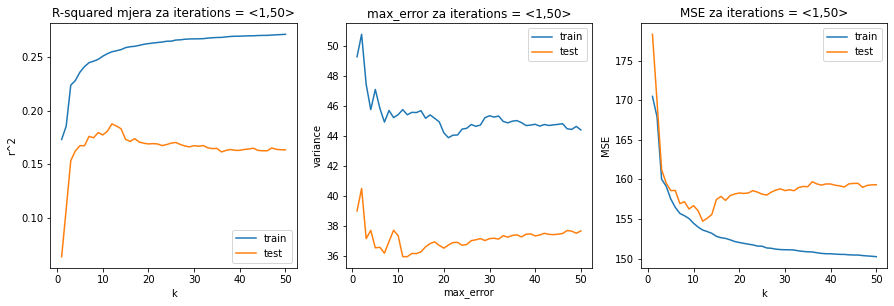

In [288]:
maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

ax[0].plot(np.arange(1,k+1),treeScoresTrain1,label='train')
ax[0].plot(np.arange(1,k+1),treeScoresTest1,label='test')
ax[0].set(xlabel='k', ylabel='r^2')
ax[0].title.set_text(f"R-squared mjera za iterations = <1,{k}>")
ax[0].legend()

ax[1].plot(np.arange(1,k+1),treeScoresTrain2,label='train')
ax[1].plot(np.arange(1,k+1),treeScoresTest2,label='test')
ax[1].set(xlabel='max_error', ylabel='variance')
ax[1].title.set_text(f"max_error za iterations = <1,{k}>")
ax[1].legend()

ax[2].plot(np.arange(1,k+1),treeScoresTrain3,label='train')
ax[2].plot(np.arange(1,k+1),treeScoresTest3,label='test')
ax[2].set(xlabel='k', ylabel='MSE')
ax[2].title.set_text(f"MSE za iterations = <1,{k}>")
ax[2].legend()


plt.show()

### Najbolji hiperparametar $iterations$ nađen

In [289]:

model = CatBoostRegressor(iterations=index_of_maximum,
                          learning_rate=1,
                          depth=2)

model.fit(train_data, train_labels)

pred = model.predict(eval_data)

0:	learn: 13.0578783	total: 604us	remaining: 6.04ms
1:	learn: 12.9584530	total: 1.36ms	remaining: 6.11ms
2:	learn: 12.6504686	total: 1.88ms	remaining: 5.02ms
3:	learn: 12.6153855	total: 2.43ms	remaining: 4.26ms
4:	learn: 12.5517572	total: 3.02ms	remaining: 3.63ms
5:	learn: 12.5087184	total: 3.76ms	remaining: 3.13ms
6:	learn: 12.4783454	total: 4.43ms	remaining: 2.53ms
7:	learn: 12.4666198	total: 5.76ms	remaining: 2.16ms
8:	learn: 12.4522725	total: 6.26ms	remaining: 1.39ms
9:	learn: 12.4282418	total: 6.78ms	remaining: 678us
10:	learn: 12.4087901	total: 7.49ms	remaining: 0us


In [290]:
print("\nScores:")
data.loc['CATBoost'] = evaluateRegressor(valid_y, pred)


Scores:
Test set evaluation:
MSE: 156.03802002908412
MAE: 9.927863053601639
RMSE: 12.491517923338385
R-squared: 0.1807927779268247 , from <0,1> 


## ANN

In [291]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(100, input_dim=train_X.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(train_X, train_y, epochs=10)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
#model = load_model('cnn_model.h5')

predicted_valid_y = model.predict(valid_X)
predicted_valid_y = pd.Series([i[0] for i in predicted_valid_y])

In [ ]:
data.loc['ANN'] = evaluateRegressor(valid_y, predicted_valid_y)

## Slučajne šume

### Pretraživanje hiperparametra: $n\_estimators$

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,max_error

In [86]:
k=50

treeScoresTest1=np.zeros(k)
treeScoresTrain1=np.zeros(k)
treeScoresTest2=np.zeros(k)
treeScoresTrain2=np.zeros(k)
treeScoresTest3=np.zeros(k)
treeScoresTrain3=np.zeros(k)



#train_X, valid_X, train_y, valid_y 


for k in np.arange(1,k+1):
    rf = RandomForestRegressor(n_estimators=k)
    rf.fit(train_X,train_y)
    treeScoresTrain1[k-1]=r2_score(train_y, rf.predict(train_X))
    treeScoresTest1[k-1] =r2_score(valid_y, rf.predict(valid_X))
    treeScoresTrain2[k-1]= max_error(train_y, rf.predict(train_X))
    treeScoresTest2[k-1] = max_error(valid_y, rf.predict(valid_X))
    treeScoresTrain3[k-1]= mean_squared_error (train_y, rf.predict(train_X))
    treeScoresTest3[k-1] = mean_squared_error (valid_y, rf.predict(valid_X))

Max test: 0.011
Max train:0.4
Max test index:2


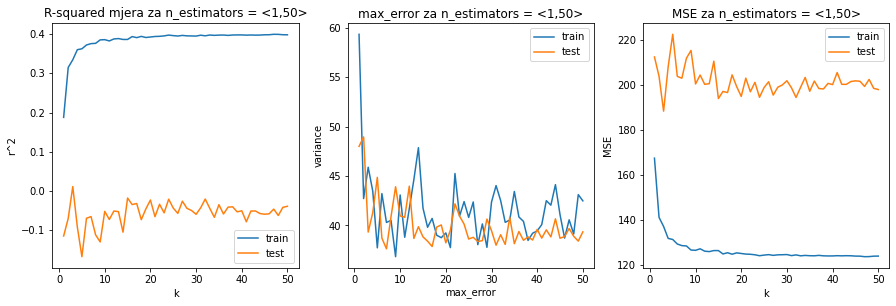

In [87]:

maximumTE = np.max(treeScoresTest1)
minimumTR = np.max(treeScoresTrain1)

print("Max test: " + str(round(maximumTE,3)) )
print("Max train:" + str(round(minimumTR,3)) )

index_of_maximum = np.where(treeScoresTest1 == maximumTE)[0][0]
print("Max test index:" + str(index_of_maximum) )


fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

ax[0].plot(np.arange(1,k+1),treeScoresTrain1,label='train')
ax[0].plot(np.arange(1,k+1),treeScoresTest1,label='test')
ax[0].set(xlabel='k', ylabel='r^2')
ax[0].title.set_text(f"R-squared mjera za n_estimators = <1,{k}>")
ax[0].legend()

ax[1].plot(np.arange(1,k+1),treeScoresTrain2,label='train')
ax[1].plot(np.arange(1,k+1),treeScoresTest2,label='test')
ax[1].set(xlabel='max_error', ylabel='variance')
ax[1].title.set_text(f"max_error za n_estimators = <1,{k}>")
ax[1].legend()

ax[2].plot(np.arange(1,k+1),treeScoresTrain3,label='train')
ax[2].plot(np.arange(1,k+1),treeScoresTest3,label='test')
ax[2].set(xlabel='k', ylabel='MSE')
ax[2].title.set_text(f"MSE za n_estimators = <1,{k}>")
ax[2].legend()


plt.show()



### Našli smo $\text{n_estimators}$ koji daje najmanju grešku nad $test$ skupom:

In [88]:
rf = RandomForestRegressor(n_estimators=index_of_maximum)
rf.fit(train_X,train_y)
# Predictions
predictions = rf.predict(valid_X)

In [227]:

data.loc['Random forest'] =evaluateRegressor(valid_y, predictions)

Test set evaluation:
MSE: 210.8590083750539
MAE: 11.507384384542474
RMSE: 14.52098510346505
R-squared: -0.1070200869495499 , from <0,1> 


## SVM

In [270]:
from sklearn.svm import SVR
def SV_reg(kernel,train_X, train_Y):
    model=SVR(kernel)
    model.fit(train_X, train_Y)
    return model


SVM_model= SV_reg("linear",train_X, train_y)
pred_linear = SVM_model.predict(valid_X)
linear_rmse = np.sqrt(mean_squared_error(valid_y,pred_linear))

SVM_model= SV_reg("poly",train_X, train_y)
pred_poly = SVM_model.predict(valid_X)
poly_rmse = np.sqrt(mean_squared_error(valid_y,pred_poly))

SVM_model= SV_reg("sigmoid",train_X, train_y)
pred_sigmoid = SVM_model.predict(valid_X)
sigmoid_rmse = np.sqrt(mean_squared_error(valid_y,pred_sigmoid))

SVM_model= SV_reg("rbf",train_X, train_y)
pred_rbf = SVM_model.predict(valid_X)
rbf_rmse = np.sqrt(mean_squared_error(valid_y,pred_rbf))



data = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse])}
table_rmse=pd.DataFrame(data)
table_rmse

,kernel,Test RMSE
0,linear,12.621032
1,polynomial,12.974213
2,sigmoid,23.503523
3,rbf,12.717795


### Umjesto ručnog pretraživanja hiperparametara $C$ i $\text{gamma}\ \gamma$ , koristimo funkciju $GridSearchCV$ za traženje hp. za 3 jezgrene fje. s najmanjom greškom

In [50]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
parameters = [{'kernel': ['linear','polynomial','rbf'], 'gamma': [2e-2, 2e-1, 1,  8],'C': [2e-3,2e-2, 2, 4]}]
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

svr_gs.fit(train_X, train_y)
print(svr_gs.best_params_)

{'C': 4, 'gamma': 0.02, 'kernel': 'linear'}


 Naći čemo npr. {'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [272]:
regressor = SVR(C=2,gamma=0.002,kernel='linear')
#regressor = SVR(**svr_gs.best_params_)
regressor.fit(train_X,train_y)
pred=regressor.predict(valid_X)

In [273]:
data.loc['SVR best'] = evaluateRegressor(valid_y,pred)

Test set evaluation:
MSE: 159.6791484623105
MAE: 10.118204685761626
RMSE: 12.63642150540692
R-squared: 0.1616766759124627 , from <0,1> 


AttributeError: 'dict' object has no attribute 'loc'

# DoWhy kauzalna analiza

## Priprema podataka

In [231]:
data_X_labeled= encode_data(df,enc_type="LABEL")
data_y_labeled= pd.cut(Y,
       5, labels=[1,2,3,4,5])

spojeno = pd.concat([data_X_labeled, data_y_labeled], axis=1)

In [232]:
spojeno.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'AVERAGE'],
      dtype='object')

## Analiza

In [233]:
import dowhy
from dowhy import CausalModel

In [234]:
model=CausalModel(
        data = spojeno,
        treatment='lunch',
        outcome='AVERAGE',
        common_causes=['gender','test preparation course', 'parental level of education','race/ethnicity']
        )

In [235]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|parental level of education,gender,test preparati
d[lunch]                                                                      

                          
on course,race/ethnicity))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity,U) = P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [236]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
print(estimate)
print("Causal Estimate is " + str(estimate.value))
data_1 = spojeno[spojeno["lunch"]==1]
data_0 = spojeno[spojeno["race/ethnicity"]==0]
print("ATE", np.mean(data_1["AVERAGE"].cat.codes)- np.mean(data_0["AVERAGE"].cat.codes))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(AVERAGE|parental level of education,gender,test preparati
d[lunch]                                                                      

                          
on course,race/ethnicity))
                          
Estimand assumption 1, Unconfoundedness: If U→{lunch} and U→AVERAGE then P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity,U) = P(AVERAGE|lunch,parental level of education,gender,test preparation course,race/ethnicity)

## Realized estimand
b: AVERAGE~lunch+parental level of education+gender+test preparation course+race/ethnicity
Target units: ate

## Estimate
Mean value: 0.48169465924595434
p-value: [5.06520702e-22]

Causal Estimate is 0.48169465924595434
ATE 0.4540545248671717


refute steps

    The refute steps tests the strength and validity of the causal effect found by the estimate step. There are a variety of different refutation methods, eg. Subset Validation (using only a subset of the data to estimate the causal effect) or Placebo Treatment (turning the treatment into a placebo and seeing its effect on the outcome (the placebo treatment refutation expects the causal effect to go down)) In this case, we’ll be adding an irrelevant common cause to test the strength of the causal relationship between the treatment and outcome. This is useful because it changes the causal model but not the relationship between y_factual and treatment.

In [237]:
refute_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute_results)

Refute: Add a Random Common Cause
Estimated effect:0.48169465924595434
New effect:0.48171404025395903



Adding a random common cause didn’t have much of an effect on the causal effect (as expected) and so we can be more assured of the strength of the causal relationship.

# Rezultati

Usporedimo rezultate koje smo dobili:

In [293]:
data

,MSE,MAE,RMSE,R^2
linearna,160.689692,10.154567,12.676344,0.156371
Multi-Lasso,178.874422,10.999074,13.373589,0.230111
LightGBM,170.118040,10.250946,13.042931,0.106872
CATBoost,156.038020,9.927863,12.491518,0.180793


### 1) Linearna regresija

Objasnjena varijanca = 0.31

R2 = 0.30

MSE = 146.31


### 2) Lasso regresija

math score       13.860696

reading score    12.818428

writing score    12.563250

dtype: float64

Scores:

MSE: 171.4220845033959

MAE: 10.427402013978332

RMSE: 13.080791496714767

R-squared: 0.256177633475969 , from <0,1> 

### 3) Ridge regresija

Objasnjena varijanca = 0.31

R2 = 0.30

MSE = 147.49

### 4) LightGBM

#### Training set: 

MSE: 137.64572706425244

MAE: 9.370538765975732

RMSE: 11.732251576924714

R-squared: 0.3197861707087939 , from <0,1> 

#### Test set:

MSE: 157.60183185692952

MAE: 10.030038841736843

RMSE: 12.55395682073702

R-squared: 0.23452270735099223 , from <0,1> 

### 5) CATBoost

residual: 12.201670629835073

Scores:

#### Training set:

MSE: 151.84207703449752

MAE: 9.851195477728904

RMSE: 12.322421719552432

R-squared: 0.24963104289497606 , from <0,1> 

#### Test set:

MSE: 148.8807661589799

MAE: 9.798469509213694

RMSE: 12.201670629835077

R-squared: 0.27688121093450935 , from <0,1> 

### 6) ANN

residual: 55.85805384144501

#### Test set

MSE: 3049.504034898524

MAE: 53.3235610850652

RMSE: 55.22231464633227

R-squared: -13.811541623928848 , from <0,1> 

### 7) Slučajne šume

residual: 13.338086174261672

#### Test set

MSE: 177.90454279203027

MAE: 10.439747508369027

RMSE: 13.338086174261669

R-squared: 0.1359117710634964 , from <0,1> 

### 8) SVM

#### Training Set

MSE: 171.80606176871777

MAE: 10.350196062160261

RMSE: 13.107481137454204

R-squared: 0.15097357786784782 , from <0,1> 

#### Test Set

MSE: 167.5987303747367

MAE: 10.30968181798135

RMSE: 12.945992830785004

R-squared: 0.18596744170379642 , from <0,1> 